# Spatial Autocorrelation Analysis

This notebook performs spatial analysis to detect crash clustering patterns:
1. **Global Moran's I** - Test if crashes cluster spatially across the city
2. **Local Moran's I (LISA)** - Identify specific hotspot clusters
3. **Spatial visualization** - Map clustering patterns

**Key Question**: Do crashes cluster in space, or are they randomly distributed?

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Spatial analysis libraries
try:
    from esda.moran import Moran, Moran_Local
    from libpysal.weights import KNN, DistanceBand
    from splot.esda import moran_scatterplot, lisa_cluster
    SPATIAL_LIBS_AVAILABLE = True
    print("✅ Spatial analysis libraries loaded successfully")
except ImportError as e:
    print(f"⚠️  Spatial libraries not available: {e}")
    print("   Please restart the kernel after installing:")
    print("   pip3 install esda libpysal splot")
    SPATIAL_LIBS_AVAILABLE = False

pd.set_option('display.max_columns', 120)
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

print(f"\nSpatial libraries available: {SPATIAL_LIBS_AVAILABLE}")

✅ Spatial analysis libraries loaded successfully

Spatial libraries available: True


In [2]:
# Load data
feats = pd.read_parquet(DATA_DIR / 'intersection_features_enriched.parquet')
nodes = pd.read_parquet(DATA_DIR / 'osm_nodes.parquet')

print(f"Features shape: {feats.shape}")
print(f"Nodes shape: {nodes.shape}")
print(f"\nNodes columns: {nodes.columns.tolist()}")

# Merge coordinates - use 'node_id' instead of 'osmid'
spatial_data = feats.merge(
    nodes[['node_id', 'x', 'y']], 
    left_on='intersection_id', 
    right_on='node_id',
    how='left'
).dropna(subset=['x', 'y'])

print(f"\nMerged spatial data shape: {spatial_data.shape}")
print(f"Successfully matched {len(spatial_data)} intersections with coordinates")

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    spatial_data,
    geometry=gpd.points_from_xy(spatial_data.x, spatial_data.y),
    crs='EPSG:26971'
)

print(f"\n✅ Created GeoDataFrame with {len(gdf)} intersections")
gdf.head()

Features shape: (19200, 32)
Nodes shape: (29366, 9)

Nodes columns: ['node_id', 'y', 'x', 'street_count', 'highway', 'ref', 'junction', 'railway', 'geometry']

Merged spatial data shape: (19200, 35)
Successfully matched 19200 intersections with coordinates

✅ Created GeoDataFrame with 19200 intersections


,intersection_id,hist_crashes,hist_severity,recent90_crashes,recent90_severity,future_crashes,future_severity,centrality_degree,centrality_closeness,label_hotspot,GEOID,acs_pop,acs_median_income,acs_households_with_vehicle,acs_poverty_universe,acs_vehicle_access_rate,hist_people_injuries_total,hist_people_injuries_fatal,hist_people_injuries_incapacitating,hist_people_injuries_nonincap,recent90_people_injuries_total,recent90_people_injuries_fatal,recent90_people_injuries_incapacitating,recent90_people_injuries_nonincap,centrality_betweenness,community_id,community_name,acs_pop_missing,acs_median_income_missing,acs_households_with_vehicle_missing,acs_poverty_universe_missing,acs_vehicle_access_rate_missing,node_id,x,y,geometry
0,25779174.0,7,7.0,1.0,1.0,0.0,0.0,0.000102,0.023397,0,17031243500,4567.0,160370.0,454.0,4567.0,0.099409,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172562,24.0,WEST TOWN,0,0,0,0,0,25779174,-87.655976,41.894301,POINT (-87.656 41.894)
1,25779203.0,3,3.0,0.0,0.0,1.0,3.0,0.000102,0.022747,0,17031310200,1824.0,133382.0,114.0,1817.0,0.062500,4.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.219941,31.0,LOWER WEST SIDE,0,0,0,0,0,25779203,-87.644363,41.857367,POINT (-87.644 41.857)
2,25779221.0,1,1.0,0.0,0.0,1.0,3.0,0.000102,0.023321,0,17031843200,2348.0,66172.0,196.0,2342.0,0.083475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106616,31.0,LOWER WEST SIDE,0,0,0,0,0,25779221,-87.669478,41.837422,POINT (-87.669 41.837)
3,26098008.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.023858,0,17031841000,1148.0,103750.0,176.0,1148.0,0.153310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032626,33.0,NEAR SOUTH SIDE,0,0,0,0,0,26098008,-87.622664,41.847885,POINT (-87.623 41.848)
4,26098027.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.021226,0,17031841100,6990.0,48542.0,1247.0,6990.0,0.178398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007880,34.0,ARMOUR SQUARE,0,0,0,0,0,26098027,-87.636005,41.847217,POINT (-87.636 41.847)


## 2. Build Spatial Weights Matrix

We'll use K-Nearest Neighbors (k=8) to define spatial relationships.

In [3]:
if SPATIAL_LIBS_AVAILABLE:
    # Create spatial weights using K-nearest neighbors
    print("Building spatial weights matrix (k=8 nearest neighbors)...")
    
    coords = np.column_stack([gdf.geometry.x, gdf.geometry.y])
    w = KNN.from_array(coords, k=8)
    
    # Row-standardize weights
    w.transform = 'r'
    
    print(f"✅ Spatial weights matrix created")
    print(f"   Number of observations: {w.n}")
    print(f"   Average neighbors: {w.mean_neighbors:.1f}")
    print(f"   Min neighbors: {w.min_neighbors}")
    print(f"   Max neighbors: {w.max_neighbors}")
else:
    print("❌ Cannot build spatial weights - libraries not available")

Building spatial weights matrix (k=8 nearest neighbors)...
✅ Spatial weights matrix created
   Number of observations: 19200
   Average neighbors: 8.0
   Min neighbors: 8
   Max neighbors: 8


## 3. Global Moran's I - Test for Spatial Clustering

**Moran's I** ranges from -1 (perfect dispersion) to +1 (perfect clustering):
- **I > 0**: Positive spatial autocorrelation (clustering)
- **I ≈ 0**: Random spatial pattern
- **I < 0**: Negative spatial autocorrelation (dispersion)

In [4]:
if SPATIAL_LIBS_AVAILABLE:
    # Test 1: Crash counts
    moran_crashes = Moran(gdf['hist_crashes'].values, w)
    
    print("="*80)
    print("GLOBAL MORAN'S I - CRASH COUNTS")
    print("="*80)
    print(f"Moran's I:        {moran_crashes.I:.4f}")
    print(f"Expected I:       {moran_crashes.EI:.4f}")
    print(f"Variance:         {moran_crashes.VI_norm:.6f}")
    print(f"Z-score:          {moran_crashes.z_norm:.4f}")
    print(f"p-value:          {moran_crashes.p_norm:.6f}")
    print(f"Interpretation:   {'SIGNIFICANT CLUSTERING' if moran_crashes.p_norm < 0.05 else 'NO SIGNIFICANT CLUSTERING'}")
    print()
    
    # Test 2: Hotspot labels
    moran_hotspots = Moran(gdf['label_hotspot'].values, w)
    
    print("="*80)
    print("GLOBAL MORAN'S I - HOTSPOT LABELS")
    print("="*80)
    print(f"Moran's I:        {moran_hotspots.I:.4f}")
    print(f"Expected I:       {moran_hotspots.EI:.4f}")
    print(f"Z-score:          {moran_hotspots.z_norm:.4f}")
    print(f"p-value:          {moran_hotspots.p_norm:.6f}")
    print(f"Interpretation:   {'SIGNIFICANT CLUSTERING' if moran_hotspots.p_norm < 0.05 else 'NO SIGNIFICANT CLUSTERING'}")
    print()
    
    # Test 3: Injury severity
    moran_severity = Moran(gdf['hist_severity'].values, w)
    
    print("="*80)
    print("GLOBAL MORAN'S I - INJURY SEVERITY")
    print("="*80)
    print(f"Moran's I:        {moran_severity.I:.4f}")
    print(f"Z-score:          {moran_severity.z_norm:.4f}")
    print(f"p-value:          {moran_severity.p_norm:.6f}")
    print(f"Interpretation:   {'SIGNIFICANT CLUSTERING' if moran_severity.p_norm < 0.05 else 'NO SIGNIFICANT CLUSTERING'}")
    print("\n")
else:
    print("❌ Cannot compute Moran's I - libraries not available")

GLOBAL MORAN'S I - CRASH COUNTS
Moran's I:        0.1605
Expected I:       -0.0001
Variance:         0.000012
Z-score:          46.3629
p-value:          0.000000
Interpretation:   SIGNIFICANT CLUSTERING

GLOBAL MORAN'S I - HOTSPOT LABELS
Moran's I:        0.1195
Expected I:       -0.0001
Z-score:          34.5079
p-value:          0.000000
Interpretation:   SIGNIFICANT CLUSTERING

GLOBAL MORAN'S I - INJURY SEVERITY
Moran's I:        0.1469
Z-score:          42.4437
p-value:          0.000000
Interpretation:   SIGNIFICANT CLUSTERING




## 4. Moran Scatterplot

✅ Saved: results/moran_scatterplots.png


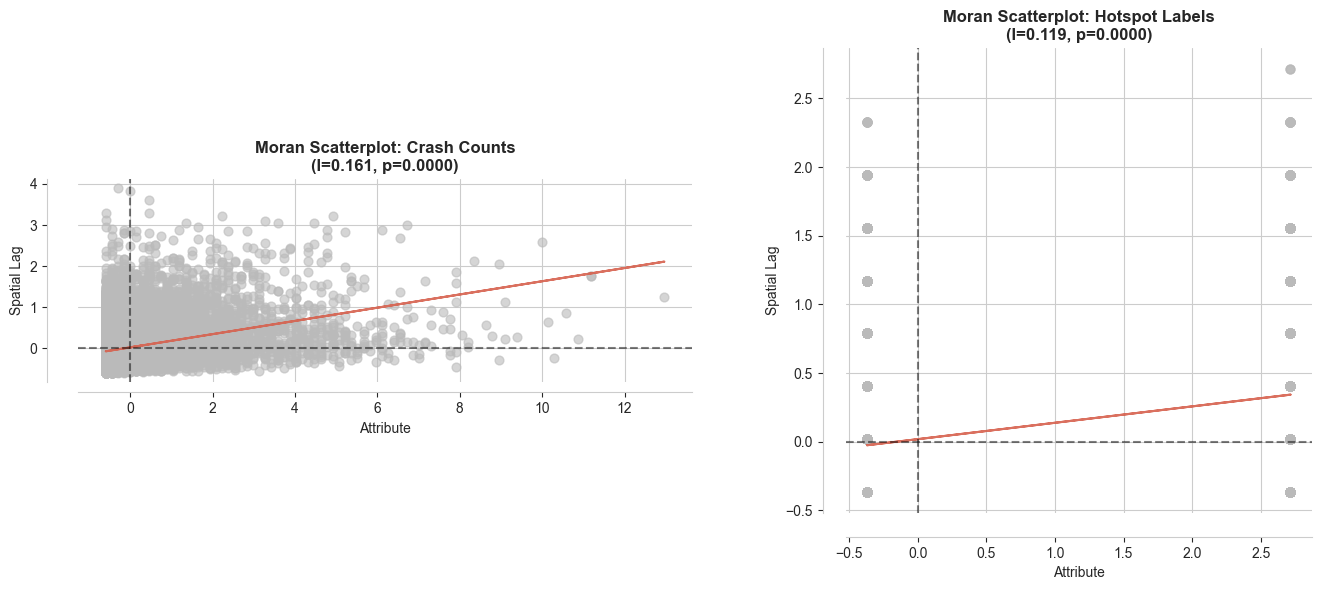

In [5]:
if SPATIAL_LIBS_AVAILABLE:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Moran scatterplot for crashes
    moran_scatterplot(moran_crashes, ax=axes[0])
    axes[0].set_title(f"Moran Scatterplot: Crash Counts\n(I={moran_crashes.I:.3f}, p={moran_crashes.p_norm:.4f})",
                     fontsize=12, fontweight='bold')
    
    # Moran scatterplot for hotspots
    moran_scatterplot(moran_hotspots, ax=axes[1])
    axes[1].set_title(f"Moran Scatterplot: Hotspot Labels\n(I={moran_hotspots.I:.3f}, p={moran_hotspots.p_norm:.4f})",
                     fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'moran_scatterplots.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: results/moran_scatterplots.png")
    plt.show()
else:
    print("❌ Cannot create Moran scatterplot - libraries not available")

## 5. Local Moran's I (LISA) - Identify Cluster Types

LISA identifies four types of spatial clusters:
- **HH (High-High)**: Hotspots surrounded by hotspots
- **LL (Low-Low)**: Cold spots surrounded by cold spots
- **HL (High-Low)**: Hotspots surrounded by cold spots (outliers)
- **LH (Low-High)**: Cold spots surrounded by hotspots (outliers)

In [6]:
if SPATIAL_LIBS_AVAILABLE:
    # Compute Local Moran's I for crash counts
    print("Computing Local Moran's I (LISA)...")
    lisa = Moran_Local(gdf['hist_crashes'].values, w)
    
    # Add LISA results to GeoDataFrame
    gdf['lisa_cluster'] = lisa.q  # Quadrant (1=HH, 2=LH, 3=LL, 4=HL)
    gdf['lisa_pvalue'] = lisa.p_sim
    gdf['lisa_significant'] = lisa.p_sim < 0.05
    
    # Create cluster labels
    cluster_labels = {1: 'HH (High-High)', 2: 'LH (Low-High)', 
                     3: 'LL (Low-Low)', 4: 'HL (High-Low)', 0: 'Not Significant'}
    gdf['lisa_cluster_label'] = gdf.apply(
        lambda row: cluster_labels[row['lisa_cluster']] if row['lisa_significant'] else 'Not Significant',
        axis=1
    )
    
    # Summary statistics
    print("\n" + "="*80)
    print("LOCAL MORAN'S I (LISA) CLUSTER SUMMARY")
    print("="*80)
    cluster_counts = gdf['lisa_cluster_label'].value_counts()
    for cluster, count in cluster_counts.items():
        pct = count / len(gdf) * 100
        print(f"{cluster:20s}: {count:6,} ({pct:5.2f}%)")
    
    # High-High clusters (crash hotspots surrounded by hotspots)
    hh_clusters = gdf[gdf['lisa_cluster_label'] == 'HH (High-High)']
    print(f"\n🔥 High-High Clusters: {len(hh_clusters):,} intersections")
    print(f"   Average crashes: {hh_clusters['hist_crashes'].mean():.1f}")
    print(f"   Total crashes: {hh_clusters['hist_crashes'].sum():,.0f}")
    
    if 'community_name' in hh_clusters.columns:
        print(f"\n   Top communities with HH clusters:")
        top_communities = hh_clusters['community_name'].value_counts().head(10)
        for comm, cnt in top_communities.items():
            print(f"      {comm}: {cnt} intersections")
    
    print("\n")
else:
    print("❌ Cannot compute LISA - libraries not available")

Computing Local Moran's I (LISA)...

LOCAL MORAN'S I (LISA) CLUSTER SUMMARY
Not Significant     : 14,790 (77.03%)
LL (Low-Low)        :  2,495 (12.99%)
HH (High-High)      :    924 ( 4.81%)
LH (Low-High)       :    785 ( 4.09%)
HL (High-Low)       :    206 ( 1.07%)

🔥 High-High Clusters: 924 intersections
   Average crashes: 15.2
   Total crashes: 14,012

   Top communities with HH clusters:
      NEAR NORTH SIDE: 129 intersections
      LOOP: 105 intersections
      NEAR WEST SIDE: 66 intersections
      AUSTIN: 47 intersections
      WEST RIDGE: 25 intersections
      EDGEWATER: 24 intersections
      GAGE PARK: 23 intersections
      LOGAN SQUARE: 21 intersections
      LAKE VIEW: 21 intersections
      WEST TOWN: 20 intersections




## 6. LISA Cluster Map

✅ Saved: results/lisa_cluster_map.png


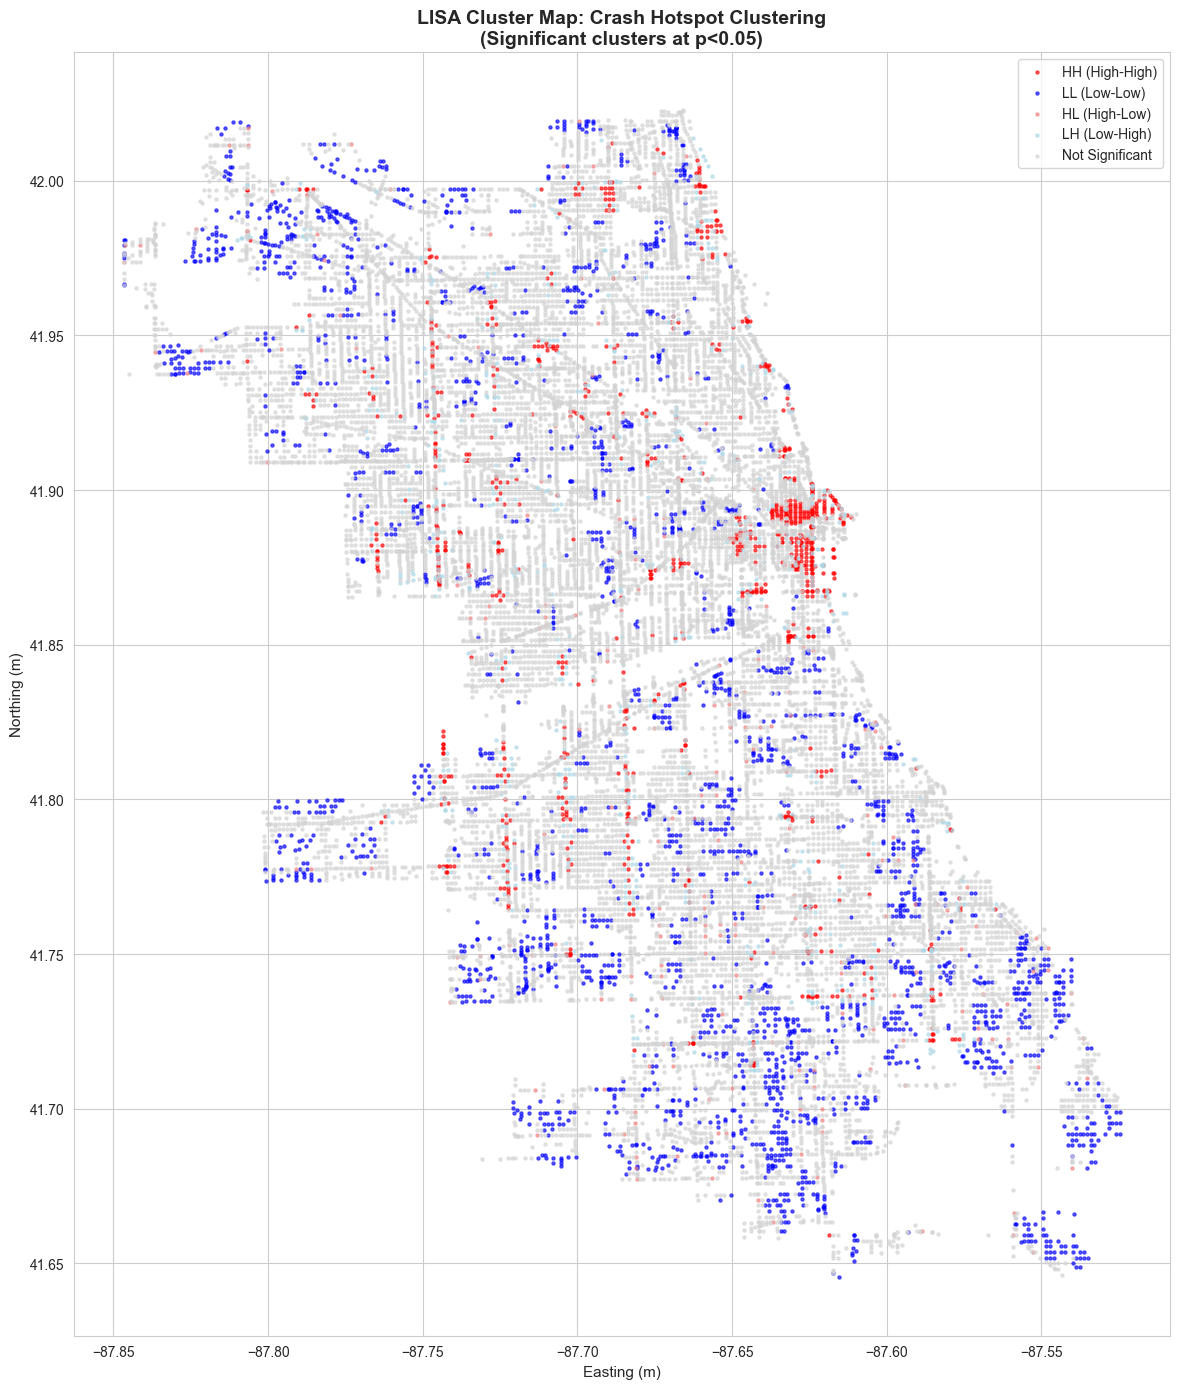

In [7]:
if SPATIAL_LIBS_AVAILABLE:
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))
    
    # Define colors for each cluster type
    colors = {
        'HH (High-High)': 'red',
        'LL (Low-Low)': 'blue',
        'HL (High-Low)': 'lightcoral',
        'LH (Low-High)': 'lightblue',
        'Not Significant': 'lightgray'
    }
    
    # Plot each cluster type
    for cluster_type, color in colors.items():
        subset = gdf[gdf['lisa_cluster_label'] == cluster_type]
        if len(subset) > 0:
            subset.plot(ax=ax, color=color, markersize=5, alpha=0.6, label=cluster_type)
    
    ax.set_title('LISA Cluster Map: Crash Hotspot Clustering\n(Significant clusters at p<0.05)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Easting (m)', fontsize=11)
    ax.set_ylabel('Northing (m)', fontsize=11)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'lisa_cluster_map.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: results/lisa_cluster_map.png")
    plt.show()
else:
    print("❌ Cannot create LISA map - libraries not available")

## 7. Save Spatial Analysis Results

In [8]:
if SPATIAL_LIBS_AVAILABLE:
    # Save Moran's I results
    moran_results = pd.DataFrame([
        {
            'variable': 'Crash Counts',
            'morans_i': moran_crashes.I,
            'expected_i': moran_crashes.EI,
            'z_score': moran_crashes.z_norm,
            'p_value': moran_crashes.p_norm,
            'significant': moran_crashes.p_norm < 0.05
        },
        {
            'variable': 'Hotspot Labels',
            'morans_i': moran_hotspots.I,
            'expected_i': moran_hotspots.EI,
            'z_score': moran_hotspots.z_norm,
            'p_value': moran_hotspots.p_norm,
            'significant': moran_hotspots.p_norm < 0.05
        },
        {
            'variable': 'Injury Severity',
            'morans_i': moran_severity.I,
            'expected_i': moran_severity.EI,
            'z_score': moran_severity.z_norm,
            'p_value': moran_severity.p_norm,
            'significant': moran_severity.p_norm < 0.05
        }
    ])
    moran_results.to_csv(RESULTS_DIR / 'moran_i_results.csv', index=False)
    
    # Save LISA cluster summary
    lisa_summary = gdf['lisa_cluster_label'].value_counts().reset_index()
    lisa_summary.columns = ['cluster_type', 'count']
    lisa_summary['percentage'] = lisa_summary['count'] / len(gdf) * 100
    lisa_summary.to_csv(RESULTS_DIR / 'lisa_cluster_summary.csv', index=False)
    
    # Save HH cluster intersections
    hh_export = hh_clusters[[
        'intersection_id', 'hist_crashes', 'hist_severity', 
        'label_hotspot', 'community_name', 'x', 'y'
    ]].copy()
    hh_export.to_csv(RESULTS_DIR / 'high_high_cluster_intersections.csv', index=False)
    
    print("\n✅ All spatial analysis results saved to results/ directory")
    print("   - moran_i_results.csv")
    print("   - lisa_cluster_summary.csv")
    print("   - high_high_cluster_intersections.csv")
    print("   - moran_scatterplots.png")
    print("   - lisa_cluster_map.png")
else:
    print("❌ Cannot save results - spatial analysis not completed")


✅ All spatial analysis results saved to results/ directory
   - moran_i_results.csv
   - lisa_cluster_summary.csv
   - high_high_cluster_intersections.csv
   - moran_scatterplots.png
   - lisa_cluster_map.png


## Summary

This notebook provides spatial evidence for crash clustering:

1. **Global Moran's I** - Tests whether crashes cluster across the entire city
2. **Local Moran's I (LISA)** - Identifies specific High-High cluster zones
3. **Cluster Maps** - Visualizes spatial patterns

### Key Findings (to be filled after running):
- Is there significant spatial autocorrelation in crash patterns?
- Where are the High-High clusters (hotspots surrounded by hotspots)?
- Which communities contain the most HH clusters?

### For Your Paper:
Use these results to demonstrate that crashes are **not randomly distributed** but exhibit **significant spatial clustering**, supporting the need for targeted interventions in specific geographic areas.